<a href="https://colab.research.google.com/github/shivamraj6288/Image-Recognition/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip3 install torch torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

In [2]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (torch.cuda.is_available())

True


In [3]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408
Receiving objects: 100% (408/408), 45.03 MiB | 47.63 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ls


ants_and_bees  sample_data


In [5]:

!ls ants_and_bees/


train  val


In [6]:
!ls ants_and_bees/train


ants  bees


In [7]:
!ls ants_and_bees/train/ants

 0013035.jpg		     408393566_b5b694119b.jpg
 1030023514_aad5c608f9.jpg   424119020_6d57481dab.jpg
 1095476100_3906d8afde.jpg   424873399_47658a91fb.jpg
 1099452230_d1949d3250.jpg   450057712_771b3bfc91.jpg
 116570827_e9c126745d.jpg    45472593_bfd624f8dc.jpg
 1225872729_6f0856588f.jpg   459694881_ac657d3187.jpg
 1262877379_64fcada201.jpg   460372577_f2f6a8c9fc.jpg
 1269756697_0bce92cdab.jpg   460874319_0a45ab4d05.jpg
 1286984635_5119e80de1.jpg   466430434_4000737de9.jpg
 132478121_2a430adea2.jpg    470127037_513711fd21.jpg
 1360291657_dc248c5eea.jpg   474806473_ca6caab245.jpg
 1368913450_e146e2fb6d.jpg   475961153_b8c13fd405.jpg
 1473187633_63ccaacea6.jpg   484293231_e53cfc0c89.jpg
 148715752_302c84f5a4.jpg    49375974_e28ba6f17e.jpg
 1489674356_09d48dde0a.jpg   506249802_207cd979b4.jpg
 149244013_c529578289.jpg    506249836_717b73f540.jpg
 150801003_3390b73135.jpg    512164029_c0a66b8498.jpg
 150801171_cd86f17ed8.jpg    512863248_43c8ce579b.jpg
 154124431_65460430f2.jpg    518773929_7

In [8]:
transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
transform_training = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                 transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                 transforms.ColorJitter(brightness=1, contrast=1, saturation=0.2),
                                transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.ImageFolder(root='ants_and_bees/train', transform=transform_training)
validation_dataset = datasets.ImageFolder(root='ants_and_bees/val',transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)

In [9]:
print (len(training_dataset))
print (len(validation_dataset))

244
153


In [10]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [11]:
# !pip3 install pillow==4.0.0

In [12]:
classes=('ants', 'bees')

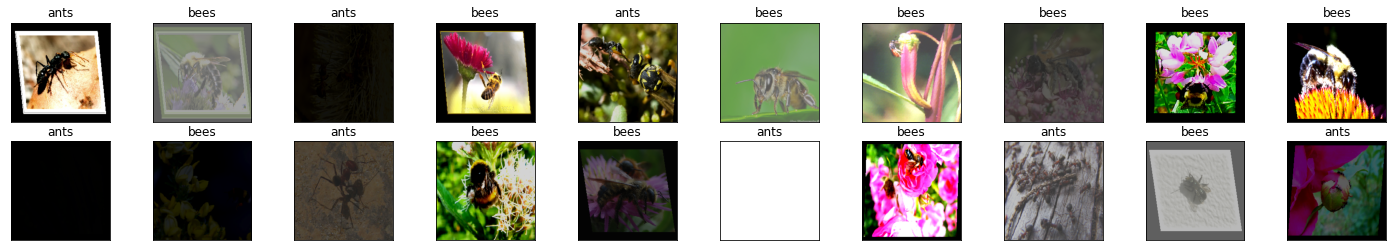

In [13]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])
  

In [27]:
model=models.vgg16(pretrained=True)

In [28]:
print (model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
for param in model.features.parameters():
    param.require_grad=False

import torch.nn as nn
n_inputs = model.classifier[6].in_features
last_layer=nn.Linear(n_inputs,  len(classes))
model.classifier[6]=last_layer
model.to(device)
# print (model.classifier[6].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [31]:
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
print('Training in process...')

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels=labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs=val_inputs.to(device)
        val_labels=val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    
print ('Training Ends')

Training in process...
epoch : 1
training loss: 0.0302, acc 0.7213 
validation loss: 0.0201, validation acc 0.8235 
epoch : 2
training loss: 0.0244, acc 0.7910 
validation loss: 0.0584, validation acc 0.6209 
epoch : 3
training loss: 0.0253, acc 0.7541 
validation loss: 0.0212, validation acc 0.8497 
epoch : 4
training loss: 0.0164, acc 0.8607 
validation loss: 0.0129, validation acc 0.9085 
epoch : 5
training loss: 0.0101, acc 0.9180 
validation loss: 0.0178, validation acc 0.9020 
epoch : 6
training loss: 0.0100, acc 0.9221 
validation loss: 0.0267, validation acc 0.8627 
epoch : 7
training loss: 0.0094, acc 0.9180 
validation loss: 0.0332, validation acc 0.8758 
Training Ends


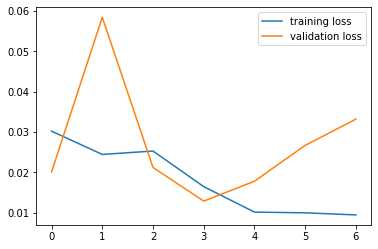

In [32]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

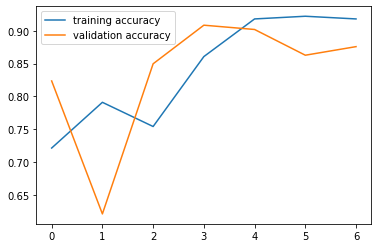

In [33]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [34]:
import PIL.ImageOps

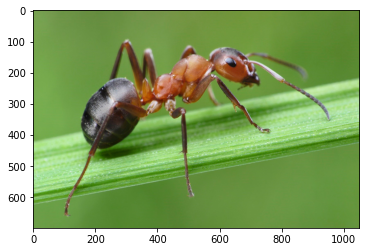

In [35]:
import requests 
from PIL import Image
url='https://daily.jstor.org/wp-content/uploads/2015/02/ants.jpg'
response=requests.get(url,stream=True)
img= Image.open(response.raw)
plt.imshow(img)


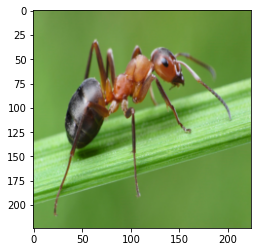

In [36]:
img=transform(img)
plt.imshow(im_convert(img))

In [37]:
image2=img.to(device)

# img=img[0].unsqueeze(0).unsqueeze(0)

image2 = image2.unsqueeze(0)
# plt.imshow(im_convert(image2))
# print (img[0].unsequeeze(0))

# img=img.view(img.shape[0],-1)
# print(image2.shape)
# print (images[0].shape)
output=model(image2)
_,pred=torch.max(output,1)
print(classes[pred.item()])



ants


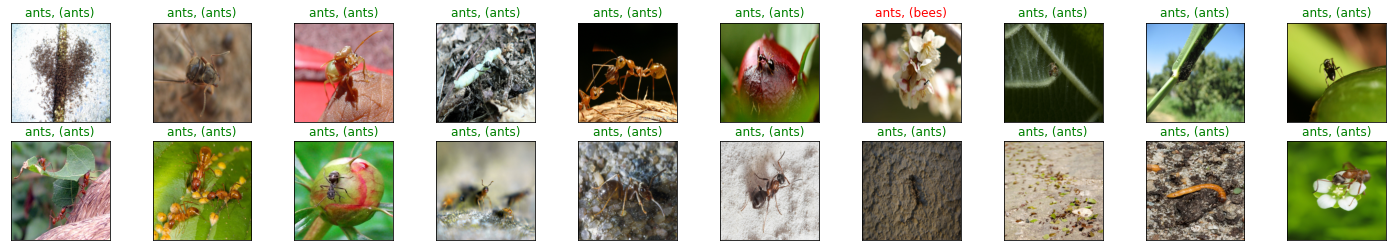

In [25]:
dataiter=iter(validation_loader)
images1, labels1=dataiter.next()
images1=images1.to(device)
labels1=labels1.to(device)
outputs1=model(images1)
_,preds1= torch.max(outputs1,1)

fig= plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax=fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images1[idx]))
    ax.set_title('{}, ({})'.format(classes[labels1[idx].item()],classes[preds1[idx].item()]), color='green' if preds1[idx]==labels1[idx] else 'red')

In [26]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'